In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.nonparametric import kaplan_meier_estimator 

In [2]:
data_x,data_y = load_veterans_lung_cancer()

Kaplan-meier estimator of the data $S(t) = \Pi_{t_i\leq t}\left(1-\frac{d_i}{n_i}\right)$

Text(0.5, 0, 'time $t$')

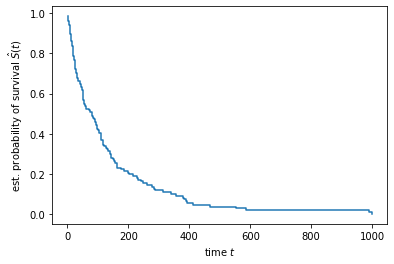

In [6]:
time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

Split the data up by type of treatment standard versus test

In [7]:
data_x["Treatment"].value_counts(normalize=True)

standard    0.50365
test        0.49635
Name: Treatment, dtype: float64

In [8]:
treatments = list(data_x["Treatment"].unique())

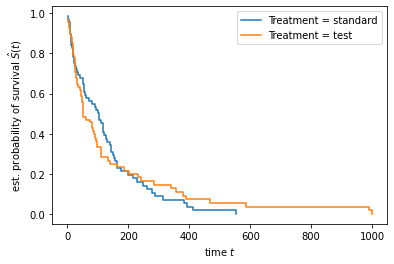

In [20]:
for treat in treatments:
    mask_treat = data_x["Treatment"] == treat
    time, survival_prob = kaplan_meier_estimator(data_y["Status"][mask_treat], data_y["Survival_in_days"][mask_treat])
    plt.step(time, survival_prob, where="post",label="Treatment = "+treat)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right")

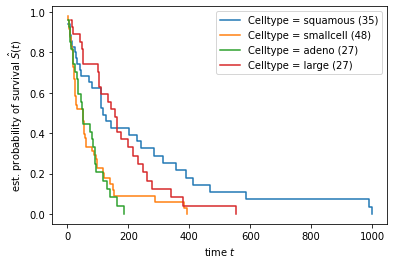

In [23]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time, survival_prob = kaplan_meier_estimator(data_y["Status"][mask], data_y["Survival_in_days"][mask])
    plt.step(time, survival_prob, where="post",label="Celltype = "+str(value)+" ("+str(mask.sum())+")")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right")

In [24]:
from sksurv.preprocessing import OneHotEncoder

In [28]:
data_x_num = OneHotEncoder().fit_transform(data_x)
data_x_num.head()
#data_x.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [29]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [30]:
set_config(display='text')

In [68]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_num,data_y)

CoxPHSurvivalAnalysis()

In [32]:
pd.Series(estimator.coef_, index=data_x_num.columns)


Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

Cox model : $\lambda(t|X)=\lambda_0(t)\exp{\sum_i\beta_iX_i}$

Here $\lambda(t)$ is the hazard function defined as the instantaneous probability that a death has occurred at time $t$ given that the patient has survived. In other words:

$
\lambda(t) = P(t|T\geq t)
= \frac{P(T=t)}{P(T\geq t)}
$
$P(T\geq t)$ is the probability of survival up to time $t$ with $P(T=t)$ being the instantaneous probability of surviving at time $t$. This allows us to rewrite this as the following:

$\lambda(t)=\frac{\frac{\partial}{\partial t}S(t)}{S(t)} = \frac{\partial}{\partial t}\log{S(t)}$

Then relating the survival function to the hazard function we find:

$S(t) = \exp{\int_0^t\lambda(t')dt'}$

Now comes estimating the hazard function, this begins with the probability of death at a given instance of death $t_j$

$P(T_j=t_j|death_{t_j})=\frac{\lambda_j(t_j)}{\sum_{t_i\geq t_j}\lambda_i(t_j)}$

Some short algebra shows $\lambda_0(t)$ cancels out and we can write the log partial likelihood as : 

$\Rightarrow \ell(x|\beta) = \sum_j\left(\vec{x_j}\cdot\vec{\beta}-\log(\sum_{t_i\geq t_j}\exp{\vec{x_i}\cdot\vec{\beta}})\right)$

Finally we need to estimate $S_0(t) = \Pi_{i:t_i\leq t}\alpha_i$

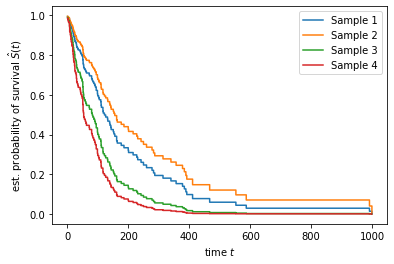

In [34]:
x_new = pd.DataFrame.from_dict({
    1: [65, 0, 0, 1, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 0],
    3: [65, 0, 1, 0, 60, 1, 0, 0],
    4: [65, 0, 1, 0, 60, 1, 0, 1]},
     columns=data_x_num.columns, orient='index')
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

Harrell's concordance index ("c" index) is used to measure performance of models. It is the ratio of correctly ordered (concordant) pairs to comparable pairs.

Two samples $i,j$ are comparable $\leftrightarrow$ the sample with lower observed time y experienced an event $y_j>y_i$ and $\delta_i=1$.

A comparable pair $(i,j)$ is concordant $\leftrightarrow$ if the estimated risk $f$ by a model is higher for subjects with lower survival time: $f_i > f_j$ and $y_j > y_i$. Otherwise the pair is said to be discordant.

Shortcomings:

-Too optimistic with increasing amount of censoring

-Not useful if a specific time range is of primary interest

In [35]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_num)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)


In [36]:
result

(0.7362562471603816, 6482, 2322, 0, 7)

Cox for each covariate individually

In [37]:
data_x_num.shape

(137, 8)

In [41]:
def fit_and_score_features(X,y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        tmp = X[:,j:j+1]
        m.fit(tmp,y)
        scores[j] = m.score(tmp,y)
    return scores

In [44]:
scores = fit_and_score_features(data_x_num.values,data_y)
pd.Series(scores, index=data_x_num.columns).sort_values(ascending=False)


Karnofsky_score          0.709280
Celltype=smallcell       0.572581
Celltype=large           0.561620
Celltype=squamous        0.550545
Treatment=test           0.525386
Age_in_years             0.515107
Months_from_Diagnosis    0.509030
Prior_therapy=yes        0.494434
dtype: float64

In [47]:
from sklearn.feature_selection import SelectKBest

from sklearn.pipeline import Pipeline

In [58]:
pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [61]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, data_x_num.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, data_y)


GridSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('encode', OneHotEncoder()),
                                       ('select',
                                        SelectKBest(k=3,
                                                    score_func=<function fit_and_score_features at 0x11fa33700>)),
                                       ('model', CoxPHSurvivalAnalysis())]),
             param_grid={'select__k': array([1, 2, 3, 4, 5, 6, 7, 8])},
             return_train_score=True)

In [62]:
results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,5,{'select__k': 5},0.716093,0.719862,0.716685,0.717547,0.001655,1,0.732087,0.742432,0.731710,0.735410,0.004968
3,4,{'select__k': 4},0.697368,0.722332,0.727324,0.715675,0.013104,2,0.732477,0.743090,0.727138,0.734235,0.006630
7,8,{'select__k': 8},0.706478,0.723320,0.716685,0.715494,0.006927,3,0.739356,0.746249,0.737519,0.741041,0.003758
5,6,{'select__k': 6},0.704453,0.719368,0.716685,0.713502,0.006491,4,0.735722,0.747565,0.731710,0.738332,0.006731
6,7,{'select__k': 7},0.700405,0.719368,0.720045,0.713272,0.009103,5,0.741173,0.742564,0.728621,0.737453,0.006271
1,2,{'select__k': 2},0.699393,0.717885,0.718365,0.711881,0.008833,6,0.732087,0.727428,0.714409,0.724642,0.007481
0,1,{'select__k': 1},0.698887,0.707510,0.712206,0.706201,0.005516,7,0.710670,0.714793,0.700445,0.708636,0.006032
2,3,{'select__k': 3},0.708502,0.714427,0.694849,0.705926,0.008198,8,0.734034,0.722559,0.716634,0.724409,0.007223


In [70]:
from sklearn.model_selection import train_test_split
from sksurv.metrics import cumulative_dynamic_auc

In [66]:
va_x_train, va_x_test, va_y_train, va_y_test = train_test_split(
    data_x_num, data_y, test_size=0.2, stratify=data_y["Status"], random_state=0
)

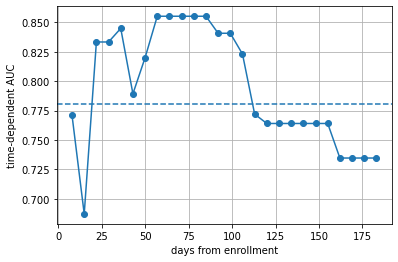

In [71]:
va_times = np.arange(8, 184, 7)
cph_risk_scores = estimator.predict(va_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    va_y_train, va_y_test, cph_risk_scores, va_times
)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [74]:
from sksurv.ensemble import RandomSurvivalForest

rsf =  RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0)

rsf.fit(va_x_train, va_y_train)

RandomSurvivalForest(min_samples_leaf=7, random_state=0)

In [75]:
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    va_x_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    va_y_train, va_y_test, rsf_risk_scores, va_times
)

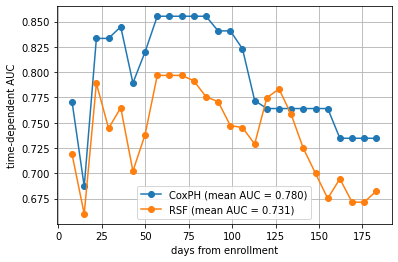

In [76]:
plt.plot(va_times, cph_auc, "o-", label="CoxPH (mean AUC = {:.3f})".format(cph_mean_auc))
plt.plot(va_times, rsf_auc, "o-", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

Time dependent Brier score can be used as an extension of a MSE if a survival function is given

$BS(t)=\frac{1}{N}\sum_{i=1}^N\left(\frac{(0-S(t,x_i))^2*1_{T_i\leq t,\delta_i=1}}{G(T_i)}+\frac{(1-S(t,xi))^2*1_{T_i>t}}{G(t)}\right)$

where $G(t)$ is the probability of censoring after time t. Concordance index only assess discrimination not calibration, where Brier assess both.



In [79]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
rsf_gbsg = RandomSurvivalForest(max_depth=2, random_state=1)
rsf_gbsg.fit(va_x_train, va_y_train)

cph_gbsg = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
cph_gbsg.fit(va_x_train, va_y_train)

CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=0.99)

In [81]:
score_cindex = pd.Series(
    [
        rsf_gbsg.score(va_x_test, va_y_test),
        cph_gbsg.score(va_x_test, va_y_test),
        0.5,
    ],
    index=["RSF", "CPH", "Random"], name="c-index",
)

score_cindex.round(3)

RSF       0.599
CPH       0.647
Random    0.500
Name: c-index, dtype: float64

In [84]:
from sksurv.datasets import load_gbsg2
gbsg_X, gbsg_y = load_gbsg2()

In [90]:
gbsg_X = OneHotEncoder().fit_transform(gbsg_X)


gbsg_X_train, gbsg_X_test, gbsg_y_train, gbsg_y_test = train_test_split(
    gbsg_X, gbsg_y, stratify=gbsg_y["cens"], random_state=1
)


In [91]:
rsf_gbsg = RandomSurvivalForest(max_depth=2, random_state=1)
rsf_gbsg.fit(gbsg_X_train, gbsg_y_train)

cph_gbsg = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
cph_gbsg.fit(gbsg_X_train, gbsg_y_train)

CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=0.99)

In [92]:
lower, upper = np.percentile(gbsg_y["time"], [10, 90])
gbsg_times = np.arange(lower, upper + 1)

In [99]:
rsf_surv_prob = np.row_stack([
    fn(gbsg_times)
    for fn in rsf_gbsg.predict_survival_function(gbsg_X_test)
])
cph_surv_prob = np.row_stack([
    fn(gbsg_times)
    for fn in cph_gbsg.predict_survival_function(gbsg_X_test)
])

In [100]:
random_surv_prob = 0.5 * np.ones(
    (gbsg_y_test.shape[0], gbsg_times.shape[0])
)

In [101]:
from sksurv.functions import StepFunction
km_func = StepFunction(
    *kaplan_meier_estimator(gbsg_y_test["cens"], gbsg_y_test["time"])
)
km_surv_prob = np.tile(km_func(gbsg_times), (gbsg_y_test.shape[0], 1))

In [98]:
from sksurv.metrics import integrated_brier_score
score_brier = pd.Series(
    [
        integrated_brier_score(gbsg_y, gbsg_y_test, prob, gbsg_times)
        for prob in (rsf_surv_prob, cph_surv_prob, random_surv_prob, km_surv_prob)
    ],
    index=["RSF", "CPH", "Random", "Kaplan-Meier"],
    name="IBS"
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

,c-index,IBS
RSF,0.599,0.194
CPH,0.647,0.189
Random,0.500,0.247
Kaplan-Meier,NaN,0.217


In [102]:
from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
)

In [103]:
cv = KFold(n_splits=3, shuffle=True, random_state=1)


In [104]:
cv_param_grid = {
    "estimator__max_depth": np.arange(1, 10, dtype=int),
}

In [105]:
gcv_cindex = GridSearchCV(
    as_concordance_index_ipcw_scorer(rsf_gbsg, tau=gbsg_times[-1]),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(gbsg_X, gbsg_y)

In [106]:
gcv_iauc = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(rsf_gbsg, times=gbsg_times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(gbsg_X, gbsg_y)

In [107]:
gcv_ibs = GridSearchCV(
    as_integrated_brier_score_scorer(rsf_gbsg, times=gbsg_times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(gbsg_X, gbsg_y)

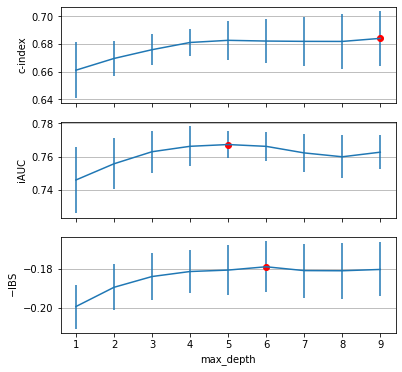

In [108]:
def plot_grid_search_results(gcv, ax, name):
    ax.errorbar(
        x=gcv.cv_results_["param_estimator__max_depth"].filled(),
        y=gcv.cv_results_["mean_test_score"],
        yerr=gcv.cv_results_["std_test_score"],
    )
    ax.plot(
        gcv.best_params_["estimator__max_depth"],
        gcv.best_score_,
        'ro',
    )
    ax.set_ylabel(name)
    ax.yaxis.grid(True)


_, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
axs[-1].set_xlabel("max_depth")

plot_grid_search_results(gcv_cindex, axs[0], "c-index")
plot_grid_search_results(gcv_iauc, axs[1], "iAUC")
plot_grid_search_results(gcv_ibs, axs[2], "$-$IBS")